In [1]:
from seq2seq import *
import tltk, jiwer
import pandas as pd


In [11]:
### load data
train_x = open('data/train_x.txt').read().splitlines()
train_y = open('data/train_y.txt').read().splitlines()
test_x = open('data/test_x.txt').read().splitlines()
test_y = open('data/test_y.txt').read().splitlines()

### additional dict data
dic_x = open('data/dic_x.txt').read().splitlines()
dic_y = open('data/dic_y.txt').read().splitlines()

### additional name data by Davor
df = pd.read_csv('data/data_from_davor.csv')
df = df[df.SAME_PREDICTED > 80][['N2','N1']]
print('Davor filtered:', df.shape)

### merge to train
train_x += df.N2.to_list()
train_y += df.N1.to_list()

print(len(train_x), len(train_y))


Davor filtered: (592, 2)
3658 3658


In [16]:
### Instantiation
data = Data()
data.set_train(train_x, train_y)
data.set_test(test_x, test_y)

### set dict data
data.set_train(dic_x, dic_y)

In [17]:
### build model without attention
seq2seq_noattn = Seq2Seq(data, attention=False)
seq2seq_noattn.build(show_summary=True)

### build model with attention
seq2seq_attn = Seq2Seq(data, attention=True)
seq2seq_attn.build(show_summary=True)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Enc_Input (InputLayer)         [(None, 55)]         0           []                               
                                                                                                  
 Enc_Embedding (Embedding)      (None, 55, 256)      18688       ['Enc_Input[0][0]']              
                                                                                                  
 Dec_Input (InputLayer)         [(None, 69)]         0           []                               
                                                                                                  
 BiDir (Bidirectional)          [(None, 256),        394240      ['Enc_Embedding[0][0]']          
                                 (None, 128),                                               

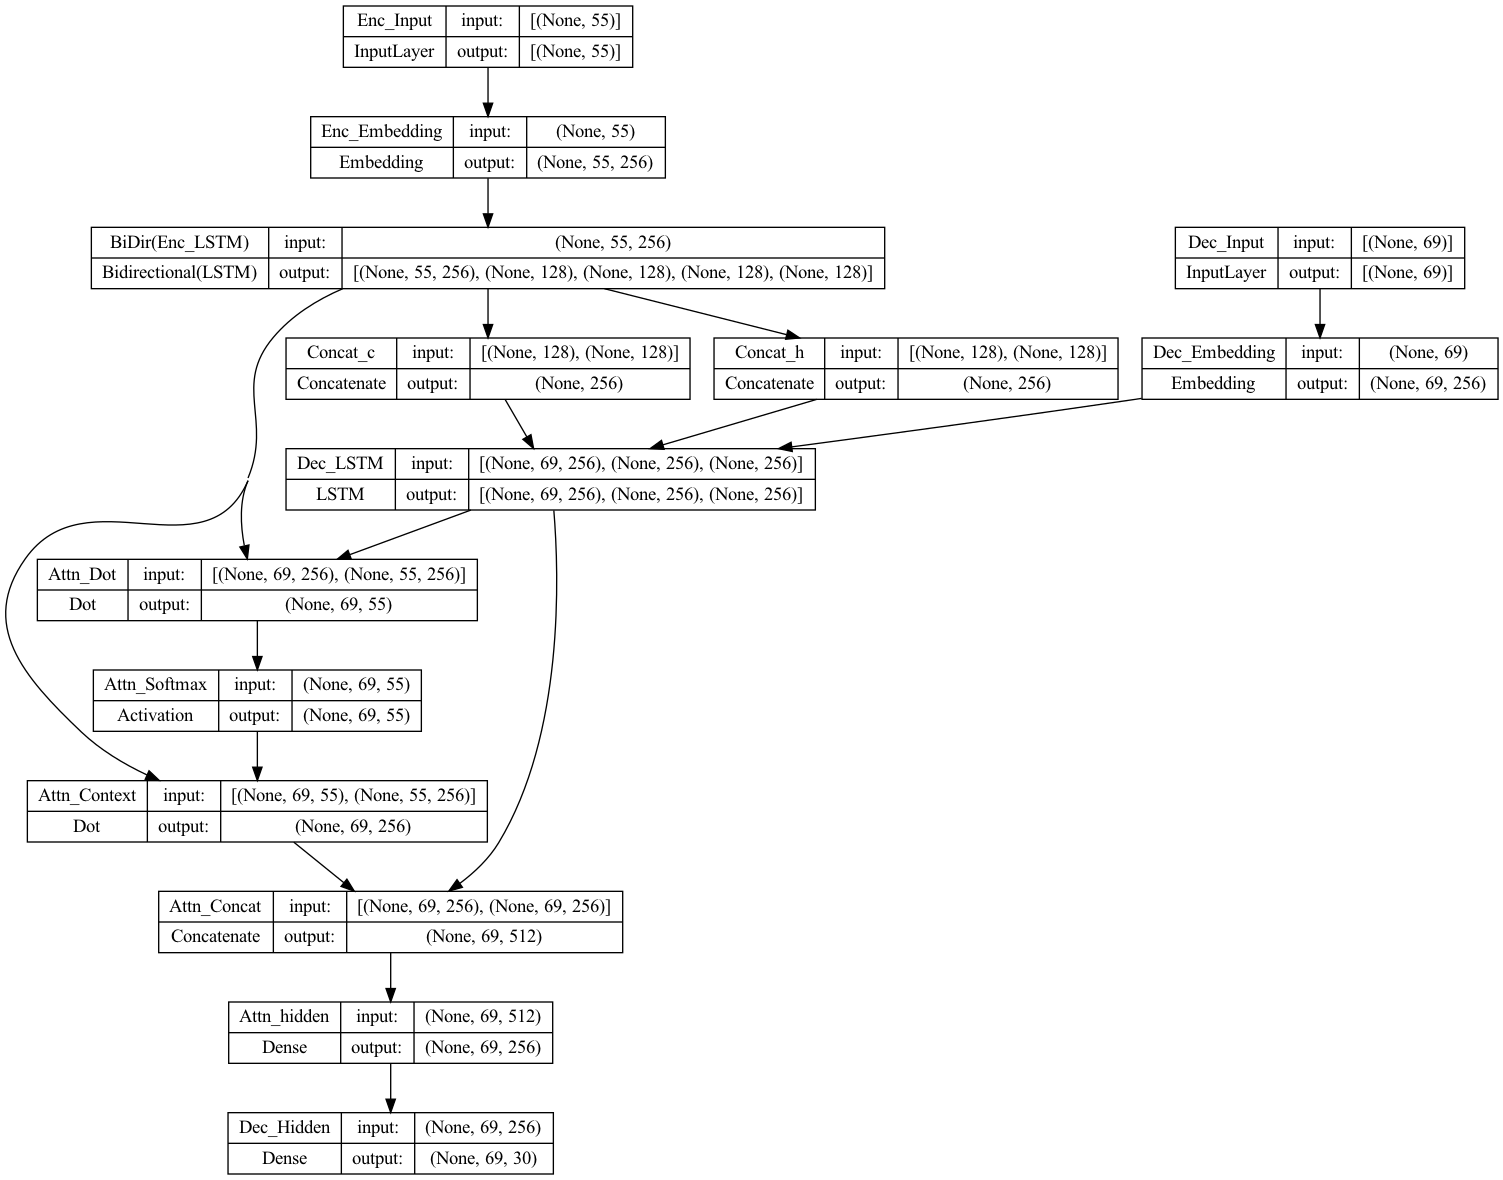

In [18]:
seq2seq_attn.show_model()

# train

In [19]:
#seq2seq_noattn.train(batch_size=128, epoch=40, dev_split=0)
seq2seq_attn.train(batch_size=128, epoch=40, dev_split=0)

Epoch 1/40
239/239 [==============================] - 196s 803ms/step - loss: 0.2542 - accuracy: 0.4599
Epoch 2/40
239/239 [==============================] - 200s 837ms/step - loss: 0.0782 - accuracy: 0.8309
Epoch 3/40
239/239 [==============================] - 200s 839ms/step - loss: 0.0346 - accuracy: 0.9270
Epoch 4/40
239/239 [==============================] - 209s 876ms/step - loss: 0.0214 - accuracy: 0.9559
Epoch 5/40
239/239 [==============================] - 211s 882ms/step - loss: 0.0151 - accuracy: 0.9691
Epoch 6/40
239/239 [==============================] - 207s 865ms/step - loss: 0.0116 - accuracy: 0.9769
Epoch 7/40
239/239 [==============================] - 203s 850ms/step - loss: 0.0092 - accuracy: 0.9818
Epoch 8/40
239/239 [==============================] - 210s 881ms/step - loss: 0.0076 - accuracy: 0.9849
Epoch 9/40
239/239 [==============================] - 209s 872ms/step - loss: 0.0064 - accuracy: 0.9875
Epoch 10/40
239/239 [==============================] - 217s 910m

KeyboardInterrupt: 

# save/load weight

In [21]:
#seq2seq_noattn.model.save_weights('model_weight/dict_lstm/weight')
seq2seq_attn.model.save_weights('model_weight/dict_attn/weight')

#seq2seq_noattn.model.load_weights('model_weight/dict_lstm/weight')
#seq2seq_attn.model.load_weights('model_weight/dict_attn/weight')

# evaluate model

In [22]:
### function for evaluation
def evaluate(df):
    cols = df.columns
    gold_list = list(df.answer)
    tempdf = pd.DataFrame(index=['WER','CER macro', 'CER micro'])

    for col in cols:
        if col in ['answer', 'thai']:
            continue
        pred_list = list(df[col])
        WER = jiwer.wer(pred_list, gold_list)
        CERmacro = np.mean([jiwer.cer(p,g) for p,g in zip(pred_list, gold_list)])
        CERmicro = sum([jiwer.cer(p,g)*len(g) for p,g in zip(pred_list, gold_list)])/sum([len(g) for g in gold_list])
        tempdf[col] = [WER, CERmacro, CERmicro]
    return tempdf

### Greedy Search

In [ ]:
#pred1 = seq2seq_noattn.predict(join_by='')
pred2 = seq2seq_attn.predict(join_by='')
#df_pred = pd.DataFrame({'thai':test_x,'pred1':pred1,'pred2':pred2, 'answer':test_y})
df_pred = pd.DataFrame({'thai':test_x,'LSTM with Davor': pred2, 'answer':test_y})
pred_tltk = [tltk.nlp.th2roman(x).replace('<s/>','').replace(' ','') for x in list(df_pred.answer)]
df_pred['tltk'] = pred_tltk
#df_pred[['thai','answer','tltk','pred1','pred2']].to_csv('pred_result/pred_dict.csv', index=False)

evaluate(df)

## the result of use Davor's Data (filtered by SAME_PREDICT > 85)

In [26]:
pred_tltk = [tltk.nlp.th2roman(x).replace('<s/>','').replace(' ','') for x in list(df_pred.answer)]
df_pred['tltk'] = pred_tltk
evaluate(df_pred)


,LSTM with Davor,tltk
WER,0.117143,0.098571
CER macro,0.025302,0.013702
CER micro,0.026166,0.012865


### Beam Search

In [38]:
pred1 = seq2seq_noattn.predict(join_by='',is_beam=True,beam_return_all=False)
pred2 = seq2seq_attn.predict(join_by='',is_beam=True,beam_return_all=False)
df = pd.DataFrame({'thai':test_x,'pred1':pred1,'pred2':pred2, 'answer':test_y})
pred_tltk = [tltk.nlp.th2roman(x).replace('<s/>','').replace(' ','') for x in list(df.answer)]
df['tltk'] = pred_tltk
df[['thai','answer','tltk','pred1','pred2']].to_csv('pred_result/pred_dict_beam.csv', index=False)

evaluate(df)

100%|██████████| 700/700 [11:38<00:00,  1.00it/s]


,pred1,pred2,tltk
WER,0.137143,0.111429,0.098571
CER macro,0.030688,0.025023,0.013702
CER micro,0.031266,0.026068,0.012865


### coding test

In [40]:
i = np.random.randint(0,810)

print(test_x[i])
print(seq2seq2.predict_one(test_x[i], is_beam=True, beam_return_all=True, join_by=''))
print(test_y[i])

อรรถยา
['atthaya', 'attaya', 'anthaya']
attaya


In [31]:
i = np.random.randint(0,700)

print(test_x[i])
print(seq2seq2.predict_one(test_x[i], is_beam=True, beam_return_all=True, join_by=''))
print(test_y[i])

มะลิ
['mali', 'malit', 'mani']
mali


In [39]:
seq2seq3 = Seq2Seq(data, attention=False)
seq2seq3.build(show_summary=False)
seq2seq3.model.load_weights('model_weight/dict_lstm/weight')

In [40]:
i = np.random.randint(0,810)

print(test_x[i])
print(seq2seq3.predict_one(test_x[i], is_beam=True, beam_return_all=True, join_by=''))
print(test_y[i])

จิราทิพย์
['chirathip', 'chiraphit', 'charithip']
chirathip
